## Import libraries

In [18]:
import xml.etree.ElementTree as ET
import os
import cv2
import albumentations as A
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import random

In [19]:
root_folder = "archive (3)"

In [20]:
def read_boxes(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    all_found_boxes = []
    for boxes in root.iter("object"):
        xmin = int(float(boxes.find("bndbox/xmin").text))
        ymin = int(float(boxes.find("bndbox/ymin").text))
        xmax = int(float(boxes.find("bndbox/xmax").text))
        ymax = int(float(boxes.find("bndbox/ymax").text))
        class_ = str(boxes.find("name").text)
        all_found_boxes.append([xmin, ymin, xmax, ymax, class_])
    return all_found_boxes

In [21]:
def visualize(image_path: str, annotation_path: str):
    image = cv2.imread(image_path)
    bboxes = read_boxes(annotation_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for box in bboxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(image)

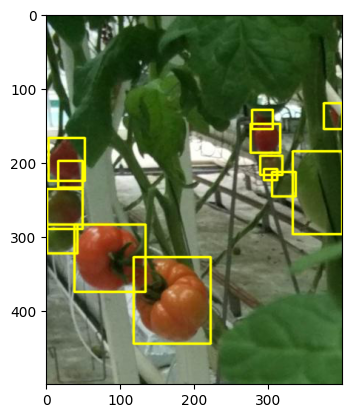

In [22]:

visualize("archive (3)/images/tomato0.png", "archive (3)/annotations/tomato0.xml")


## Split into train and val set

In [23]:
all_classes = {}
all_samples = []
for annotation in os.listdir("archive (3)/images"):
    file_name, ext = os.path.splitext(annotation)
    if ext == ".png":
        all_samples.append(file_name)
print(len(all_samples))


895


In [24]:
dataset_folder = "dataset"
train_image_folder = f"{dataset_folder}/train/images"
val_image_folder = f"{dataset_folder}/val/images"
train_label_folder = f"{dataset_folder}/train/Annotations"
val_label_folder = f"{dataset_folder}/val/Annotations"

In [25]:
root_image_folder = "archive (3)/images"
root_label_folder = "archive (3)/annotations"

In [26]:

if os.path.isdir(dataset_folder):
    shutil.rmtree(dataset_folder)

os.makedirs(train_image_folder)
os.makedirs(val_image_folder)
os.makedirs(train_label_folder)
os.makedirs(val_label_folder)
val_ratio = 0.2
print(f"The dataset has total {len(all_samples)} samples!")
val_quantity = int(val_ratio * len(all_samples))
train_quantity = len(all_samples) - val_quantity
val_samples = random.sample(all_samples, val_quantity)
train_samples = set(all_samples).difference(val_samples)
print(f"The training set has total {len(train_samples)} samples!")
print(f"The validation set has total {len(val_samples)} samples!")
for i in val_samples:
    shutil.copy(os.path.join(root_image_folder, f"{i}.png"), val_image_folder)
    shutil.copy(os.path.join(root_label_folder, f"{i}.xml"), val_label_folder)
for i in train_samples:

    shutil.copy(os.path.join(root_image_folder, f"{i}.png"), train_image_folder)
    shutil.copy(os.path.join(root_label_folder, f"{i}.xml"), train_label_folder)

The dataset has total 895 samples!
The training set has total 716 samples!
The validation set has total 179 samples!


## Augmentation

In [27]:
transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Rotate(p=0.2, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.2))

In [28]:
def writeAnnotation(xml_file: str, bboxes):
    
    tree_et = ET.parse(xml_file)
    root = tree_et.getroot()
    xml_boxes = []
    for box in root.iter("object"):
        xml_boxes.append(box)
    for index, boxes in enumerate(xml_boxes):
        if index < len(bboxes):
            true_boxes = bboxes[index]
            boxes.find("bndbox/xmin").text = str((true_boxes[0]))
            boxes.find("bndbox/ymin").text = str((true_boxes[1]))
            boxes.find("bndbox/xmax").text = str((true_boxes[2]))
            boxes.find("bndbox/ymax").text = str((true_boxes[3]))
        else:
            root.remove(boxes)
    tree_et.write(xml_file)


### Test augmentation

In [29]:
xml_file = "archive (3)/annotations/tomato13.xml"
boxes = read_boxes(xml_file)
image = cv2.imread("archive (3)/images/tomato13.png")
transformed = transform(image=image, bboxes=boxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
cv2.imwrite("test.jpg", transformed_image)
tree_et = ET.parse(xml_file)
root = tree_et.getroot()
print(len(boxes))
print(len(transformed_bboxes))
xml_boxes = []
for box in root.iter("object"):
    xml_boxes.append(box)
for index, box in enumerate(xml_boxes):
    if index < len(transformed_bboxes):
        true_boxes = transformed_bboxes[index]
        box.find("bndbox/xmin").text = str((true_boxes[0]))
        box.find("bndbox/ymin").text = str((true_boxes[1]))
        box.find("bndbox/xmax").text = str((true_boxes[2]))
        box.find("bndbox/ymax").text = str((true_boxes[3]))
    else:
        print(index)
        root.remove(box)
tree_et.write("test.xml")

6
6


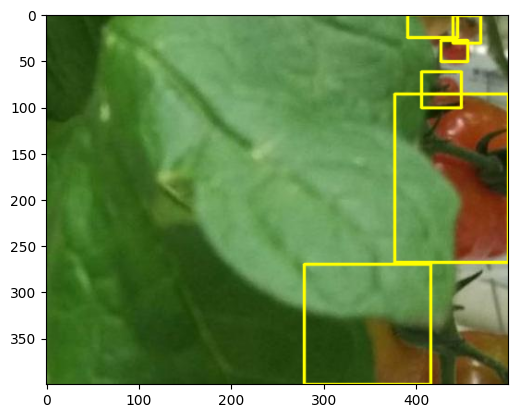

In [30]:
visualize("test.jpg", "test.xml")

### Perform augmentation on training set

In [31]:
for i in os.listdir(train_image_folder):
    filename, ext = os.path.splitext(i)
    xml_file = os.path.join(train_label_folder, f"{filename}.xml")
    boxes = read_boxes(xml_file)
    image = cv2.imread(os.path.join(train_image_folder, i))
    transformed = transform(image=image, bboxes=boxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    cv2.imwrite(os.path.join(train_image_folder, i), transformed_image)
    writeAnnotation(xml_file, transformed_bboxes)
    

## Visualize after augmentation

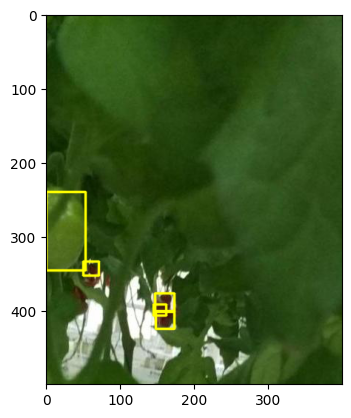

In [32]:
visualize("archive (3)/images/tomato14.png", "archive (3)/annotations/tomato14.xml")

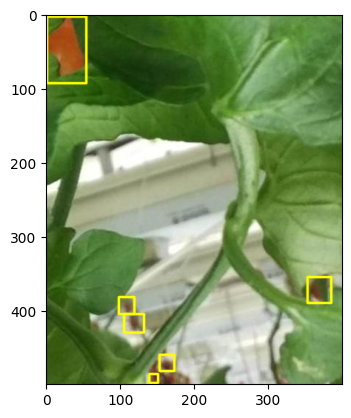

In [33]:
visualize("dataset/train/images/tomato16.png", "dataset/train/Annotations/tomato16.xml")

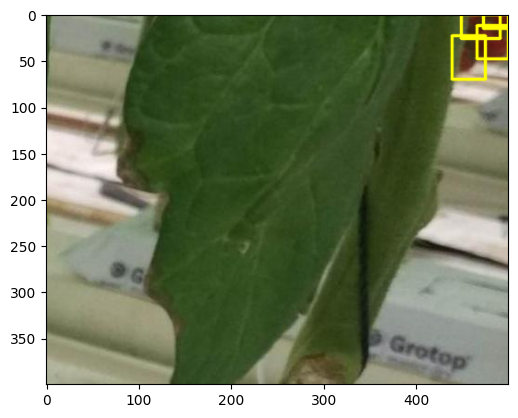

In [35]:
visualize("dataset/val/images/tomato1.png", "dataset/val/Annotations/tomato1.xml")